# Package Calling

In [ ]:
import sys

sys.path.append("../../")

In [ ]:
import datetime as dtt
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Package Settings

In [ ]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [ ]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("chained_assignment", None)

In [ ]:
plt.rcParams["font.family"] = ["Arial Unicode MS"]  # Chinese Labels
plt.rcParams["axes.unicode_minus"] = False  # Minus Sign
plt.rcParams["figure.max_open_warning"] = 0

sns.set(
    style="darkgrid",
    rc={
        "figure.figsize": (12, 6),
        "font.sans-serif": ["Arial Unicode MS", "Arial"],
    },
)

## GC Settings

In [ ]:
import gc

gc.isenabled()
gc.get_threshold()

In [ ]:
# gc.set_threshold(10,1,1)
# gc.enable()
# gc.disable()

# Modeling

In [ ]:
data_path = "/Users/chenzhou/Documents/Everything/python/COVID19/data/data_0516_SH.csv"
data_sh = pd.read_csv(
    data_path,
    dtype={
        "inbound_confirmed": int,
        "inbound_asymp": int,
        "outbound_confirmed": int,
        "outbound_asymp": int,
        "cure": int,
        "relieve": int,
    },
    parse_dates=["date"],
)

In [ ]:
data_sh["confirmed_add"] = data_sh.inbound_confirmed + data_sh.outbound_confirmed
data_sh["asymp_add"] = data_sh.inbound_asymp + data_sh.outbound_asymp
data_sh["total_add"] = data_sh.confirmed_add + data_sh.asymp_add

data_sh["confirmed_acc"] = data_sh.confirmed_add.cumsum() - 380
data_sh["asymp_acc"] = data_sh.asymp_add.cumsum() - 120
data_sh["total_affected"] = data_sh.confirmed_acc + data_sh.asymp_acc

data_sh = data_sh.loc[data_sh.date >= "2022-03-01"].reset_index(drop=True)

In [ ]:
data_sh

## Optimize BS Pars Locally

In [ ]:
from covid19 import (
    bs_coeff_local_opt,
    covid19_seer,
    growth_decision,
    model_theta_global_opt,
    next_pred,
    pred_ser,
    revise_ser,
)

In [ ]:
bs_interp_prop = 0.5
interg_interp_prop = 500.0
ser = data_sh.total_affected.iloc[28:].values
kappa, mu, tau = 0.6, 1.0, 1.8

In [ ]:
labd, lr, decay, iters, early_stop_ratio, early_stop_steps, show_process = (
    5.0,
    0.02,
    0.999,
    int(4e2),
    [1.1, 0.999],
    3,
    True,
)

In [ ]:
bs_coeff_local_opt(
    ser,
    kappa,
    mu,
    tau,
    bs_interp_prop,
    interg_interp_prop,
    labd,
    lr,
    decay,
    iters,
    early_stop_ratio,
    early_stop_steps,
    show_process,
    ser_loss_expansion=0.5,
)

## Optimize Theta Globally

In [ ]:
kappa_init, mu_init, tau_init = 0.59, 1.0, 1.81

In [ ]:
ser = data_sh.total_affected.iloc[28:].values

theta_opt, losses, fitted_opt, bs_funcs = model_theta_global_opt(
    ser,
    kappa_init=kappa_init,
    mu_init=mu_init,
    tau_init=tau_init,
    bs_interp_prop=0.5,
    interg_interp_prop=500.0,
    labd=5.0,
    bs_lr_schedule=(int(4e2), 0.02, 0.999),
    theta_lr_schedule=(int(2e2), 0.1, 0.99),
    early_stop_ratio=[1.5, 0.999],
    early_stop_steps=3,
    show_process="both",
)

In [ ]:
sns.scatterplot(x=range(len(ser)), y=ser, alpha=1.0, color="blue", s=32)
sns.lineplot(
    x=range(len(ser)), y=revise_ser(fitted_opt), alpha=0.8, color="yellow", linewidth=4
)

# Application on SZ

In [ ]:
data_sz = pd.read_csv(
    "/Users/chenzhou/Documents/Everything/python/COVID19/data/covid19_shenzhen.csv",
    dtype={
        "week_group": int,
        "adt": int,
        "imputed_adt": float,
        "adt_prop": float,
        "store_cnt": int,
        "cfm_cases": pd.Int64Dtype(),
        "asym_cases": pd.Int64Dtype(),
        "covid_group": int,
    },
    parse_dates=["date"],
)
# data_sz.fillna(0, inplace=True)
data_sz["total_add"] = data_sz.cfm_cases + data_sz.asym_cases

In [ ]:
data_modeling = data_sz.loc[
    # data_sz.week_group.isin(range(56, 78))
    data_sz.week_group.isin(range(126, 130))
    # data_sz.week_group.isin(range(162, 170))
]  # data_sz.covid_group.isin([2])
shifting = 0
data_modeling["total_affected"] = data_modeling.total_add.cumsum() + shifting

In [ ]:
data_modeling

In [ ]:
ser = np.concatenate([[0] * 0, data_modeling.total_affected.iloc[7:].values])
kappa_init, mu_init, tau_init = 0.72, 0.76, 1.43

bs_coeff_local_opt(
    ser,
    kappa=kappa_init,
    mu=mu_init,
    tau=tau_init,
    bs_interp_prop=0.5,
    interg_interp_prop=200.0,
    labd=5.0,
    lr=0.02,
    decay=0.999,
    iters=int(4e2),
    early_stop_ratio=[1.2, 0.9999],
    early_stop_steps=3,
    show_process=True,
    ser_loss_expansion=0.1,
)

In [ ]:
theta_opt

In [ ]:
# 2020 56 + 4w 0.5794437  1.0217819  1.60897016
# 2021 127 + 3w 0.60308749, 1.02070991, 1.72955825
# 2022 163 + 7w 0.61065746, 1.02502465, 1.57269699

kappa_init, mu_init, tau_init = 0.60, 1.02, 1.64

theta_opt, losses, fitted_opt, bs_funcs = model_theta_global_opt(
    ser,
    kappa_init=kappa_init,
    mu_init=mu_init,
    tau_init=tau_init,
    bs_interp_prop=0.5,
    interg_interp_prop=200.0,
    labd=5.0,
    bs_lr_schedule=(int(4e2), 0.02, 0.999),
    theta_lr_schedule=(int(5e2), 0.01, 0.9),
    early_stop_ratio=[2.0, 0.999],
    early_stop_steps=20,
    show_process="outer",
    ser_loss_expansion=0.5,
)

In [ ]:
sns.scatterplot(x=range(len(ser)), y=ser, alpha=1.0, color="blue", s=32)
sns.lineplot(
    x=range(len(ser)), y=revise_ser(fitted_opt), alpha=0.8, color="yellow", linewidth=4
)

## Prediction

In [ ]:
pred_len = 30
pred_interp = 10
pred_prev_len = 2
fitted_ser = revise_ser(fitted_opt)
pred_ser_combo = pred_ser(fitted_ser, pred_len, pred_interp, pred_prev_len, theta_opt)
pred_series = pred_ser_combo[pred_interp * pred_prev_len :][::pred_interp]
pred_series = revise_ser(pred_series, intercept=pred_series[0])

In [ ]:
sns.scatterplot(x=range(len(fitted_ser)), y=ser, alpha=1.0, color="blue", s=32)
sns.lineplot(
    x=range(len(fitted_ser)), y=fitted_ser, alpha=0.8, color="yellow", linewidth=4
)
sns.lineplot(
    x=range(len(fitted_ser) - 1, len(fitted_ser) + pred_len),
    y=pred_series,
    alpha=0.8,
    color="green",
    linewidth=4,
)

In [ ]:
growth_decision(fitted_ser, theta_opt)

## Integration

In [ ]:
theta_city = 0.60, 1.02, 1.64

In [ ]:
gt = data_modeling.total_affected.iloc[:].values
ser = gt[:19]
sns.scatterplot(x=range(len(gt)), y=gt, alpha=1.0, color="blue", s=32)
sns.scatterplot(x=range(len(ser)), y=ser, alpha=0.5, color="red", s=32)

In [ ]:
growth_flag, turning_point, stop_point, seer_ser = covid19_seer(
    ser, "LOCKDOWN", theta_city
)

In [ ]:
growth_flag, turning_point, stop_point, seer_ser

In [ ]:
sns.scatterplot(x=range(len(gt)), y=gt, alpha=1.0, color="blue", s=32)
sns.lineplot(x=range(len(seer_ser)), y=seer_ser, alpha=0.8, color="yellow", linewidth=4)

## Yearly Covid19

### 2020

#### Lockdown

In [ ]:
data_modeling = (
    data_sz.loc[
        data_sz.week_group.isin(range(56, 60))
        # data_sz.week_group.isin(range(126, 130))
        # data_sz.week_group.isin(range(162, 170))
    ]
    .sort_values(["date"])
    .reset_index(drop=True)
)
shifting = 0
data_modeling.fillna(0.0, inplace=True)
data_modeling["total_affected"] = data_modeling.total_add.cumsum() + shifting
data_modeling

In [ ]:
gt = data_modeling.iloc[:]
ser = gt.iloc[:]
sns.scatterplot(x=gt.date, y=gt.total_affected, alpha=1.0, color="blue", s=32)
sns.scatterplot(x=ser.date, y=ser.total_affected, alpha=0.5, color="red", s=32)
_ = plt.xticks(gt.date, rotation=90)

In [ ]:
lock_down_pred_list = []
for _pred_date in data_modeling.date.iloc[3:-7]:
    growth_flag, turning_point, stop_point, seer_ser = covid19_seer(
        data_modeling.loc[data_modeling.date <= _pred_date].total_affected.values,
        "LOCKDOWN",
        theta_city,
        five_day_filter=10,
    )
    if stop_point is not None:
        lock_down_pred_list.append(
            [
                _pred_date,
                data_modeling.date.iloc[0] + dtt.timedelta(days=int(stop_point)),
                1,
            ]
        )
    else:
        stop_point = 5
    for _p in range(stop_point):
        lock_down_pred_list.append(
            [_pred_date, data_modeling.date.iloc[0] + dtt.timedelta(days=int(_p)), 0]
        )

In [ ]:
heat_map_df = pd.DataFrame(
    lock_down_pred_list, columns=["pred_date", "zero_date", "flag"]
)
heat_map_df["pred_date"] = heat_map_df["pred_date"].dt.date
heat_map_df["zero_date"] = heat_map_df["zero_date"].dt.date

sns.heatmap(
    pd.pivot_table(
        heat_map_df,
        index="pred_date",
        columns="zero_date",
        values="flag",
        fill_value=0,
        aggfunc="max",
    ),
    cmap=sns.cubehelix_palette(
        start=2, rot=0, dark=0, light=0.95, reverse=False, as_cmap=True
    ),
    center=1.0,
    linewidths=1,
)

### 2021

#### Warning

In [ ]:
data_modeling = (
    data_sz.loc[
        # data_sz.week_group.isin(range(56, 60))
        data_sz.week_group.isin(range(127, 131))
        # data_sz.week_group.isin(range(162, 170))
    ]
    .sort_values(["date"])
    .reset_index(drop=True)
)
shifting = 0
data_modeling.fillna(0.0, inplace=True)
data_modeling["total_affected"] = data_modeling.total_add.cumsum() + shifting
data_modeling

In [ ]:
gt = data_modeling.iloc[:]
ser = gt.iloc[:]
sns.scatterplot(x=gt.date, y=gt.total_affected, alpha=1.0, color="blue", s=32)
sns.scatterplot(x=ser.date, y=ser.total_affected, alpha=0.5, color="red", s=32)
_ = plt.xticks(gt.date, rotation=90)

In [ ]:
warning_pred_list = []
for _pred_date in data_modeling.date.iloc[3:-7]:
    print(_pred_date)
    growth_flag, turning_point, stop_point, seer_ser = covid19_seer(
        data_modeling.loc[data_modeling.date <= _pred_date].total_affected.values,
        "WARNING",
        theta_city,
        five_day_filter=15,
    )
    if turning_point is not None:
        warning_pred_list.append(
            [
                _pred_date,
                data_modeling.date.iloc[0] + dtt.timedelta(days=int(turning_point)),
                2,
            ]
        )
    else:
        turning_point = 5
    for _p in range(turning_point):
        warning_pred_list.append(
            [
                _pred_date,
                data_modeling.date.iloc[0] + dtt.timedelta(days=int(_p)),
                0,
            ]
        )

    if stop_point is not None:
        warning_pred_list.append(
            [
                _pred_date,
                data_modeling.date.iloc[0] + dtt.timedelta(days=int(stop_point)),
                1,
            ]
        )
    else:
        stop_point = 5
    for _p in range(stop_point):
        warning_pred_list.append(
            [
                _pred_date,
                data_modeling.date.iloc[0] + dtt.timedelta(days=int(_p)),
                0,
            ]
        )

In [ ]:
heat_map_df = pd.DataFrame(
    warning_pred_list, columns=["pred_date", "zero_date", "flag"]
)
heat_map_df["pred_date"] = heat_map_df["pred_date"].dt.date
heat_map_df["zero_date"] = heat_map_df["zero_date"].dt.date

sns.heatmap(
    pd.pivot_table(
        heat_map_df,
        index="pred_date",
        columns="zero_date",
        values="flag",
        aggfunc="max",
        fill_value=0,
    ),
    cmap=sns.cubehelix_palette(
        start=2, rot=0, dark=0, light=0.95, reverse=False, as_cmap=True
    ),
    center=1.0,
    linewidths=1,
)

### 2022

#### Warning

In [ ]:
data_modeling = (
    data_sz.loc[
        # data_sz.week_group.isin(range(56, 60))
        # data_sz.week_group.isin(range(127, 131))
        data_sz.week_group.isin(range(163, 170))
    ]
    .sort_values(["date"])
    .reset_index(drop=True)
)
shifting = 0
data_modeling.fillna(0.0, inplace=True)
data_modeling["total_affected"] = data_modeling.total_add.cumsum() + shifting
data_modeling

In [ ]:
gt = data_modeling.iloc[:]
ser = gt.iloc[:]
sns.scatterplot(x=gt.date, y=gt.total_affected, alpha=1.0, color="blue", s=32)
sns.scatterplot(x=ser.date, y=ser.total_affected, alpha=0.5, color="red", s=32)
_ = plt.xticks(gt.date, rotation=90)

In [ ]:
warning_pred_list = []
for _pred_date in data_modeling.date.iloc[3:28]:
    print(_pred_date)
    growth_flag, turning_point, stop_point, seer_ser = covid19_seer(
        data_modeling.loc[data_modeling.date <= _pred_date].total_affected.values,
        "WARNING",
        theta_city,
        five_day_filter=15,
        lock_down_hard_thresh=data_modeling.loc[
            data_modeling.date <= _pred_date
        ].total_affected.values.max()
        + 1,
    )
    if turning_point is not None:
        warning_pred_list.append(
            [
                _pred_date,
                data_modeling.date.iloc[0] + dtt.timedelta(days=int(turning_point)),
                2,
            ]
        )
    else:
        turning_point = 5
    for _p in range(turning_point):
        warning_pred_list.append(
            [
                _pred_date,
                data_modeling.date.iloc[0] + dtt.timedelta(days=int(_p)),
                0,
            ]
        )

    if stop_point is not None:
        warning_pred_list.append(
            [
                _pred_date,
                data_modeling.date.iloc[0] + dtt.timedelta(days=int(stop_point)),
                1,
            ]
        )
    else:
        stop_point = 5
    for _p in range(stop_point):
        warning_pred_list.append(
            [
                _pred_date,
                data_modeling.date.iloc[0] + dtt.timedelta(days=int(_p)),
                0,
            ]
        )

In [ ]:
heat_map_df_warn = pd.DataFrame(
    warning_pred_list, columns=["pred_date", "zero_date", "flag"]
)
heat_map_df_warn["pred_date"] = heat_map_df_warn["pred_date"].dt.date
heat_map_df_warn["zero_date"] = heat_map_df_warn["zero_date"].dt.date

sns.heatmap(
    pd.pivot_table(
        heat_map_df_warn,
        index="pred_date",
        columns="zero_date",
        values="flag",
        aggfunc="max",
        fill_value=0,
    ),
    cmap=sns.cubehelix_palette(
        start=2, rot=0, dark=0, light=0.95, reverse=False, as_cmap=True
    ),
    center=1.0,
    linewidths=1,
)

#### Lockdown

In [ ]:
warning_pred_list = []
for _pred_date in data_modeling.date.iloc[28:-7]:
    print(_pred_date)
    growth_flag, turning_point, stop_point, seer_ser = covid19_seer(
        data_modeling.loc[data_modeling.date <= _pred_date].total_affected.values,
        "LOCKDOWN",
        theta_city,
        five_day_filter=15,
        lock_down_hard_thresh=data_modeling.loc[
            data_modeling.date <= _pred_date
        ].total_affected.values.max()
        + 1,
    )
    if turning_point is not None:
        warning_pred_list.append(
            [
                _pred_date,
                data_modeling.date.iloc[0] + dtt.timedelta(days=int(turning_point)),
                2,
            ]
        )
    else:
        turning_point = 5
    for _p in range(turning_point):
        warning_pred_list.append(
            [
                _pred_date,
                data_modeling.date.iloc[0] + dtt.timedelta(days=int(_p)),
                0,
            ]
        )

    if stop_point is not None:
        warning_pred_list.append(
            [
                _pred_date,
                data_modeling.date.iloc[0] + dtt.timedelta(days=int(stop_point)),
                1,
            ]
        )
    else:
        stop_point = 5
    for _p in range(stop_point):
        warning_pred_list.append(
            [
                _pred_date,
                data_modeling.date.iloc[0] + dtt.timedelta(days=int(_p)),
                0,
            ]
        )

In [ ]:
heat_map_df_lock = pd.DataFrame(
    warning_pred_list, columns=["pred_date", "zero_date", "flag"]
)
heat_map_df_lock["pred_date"] = heat_map_df_lock["pred_date"].dt.date
heat_map_df_lock["zero_date"] = heat_map_df_lock["zero_date"].dt.date

sns.heatmap(
    pd.pivot_table(
        heat_map_df_lock,
        index="pred_date",
        columns="zero_date",
        values="flag",
        aggfunc="max",
        fill_value=0,
    ),
    cmap=sns.cubehelix_palette(
        start=2, rot=0, dark=0, light=0.95, reverse=False, as_cmap=True
    ),
    center=1.0,
    linewidths=1,
)

#### Combo

In [ ]:
sns.heatmap(
    pd.pivot_table(
        pd.concat([heat_map_df_warn, heat_map_df_lock], axis=0),
        index="pred_date",
        columns="zero_date",
        values="flag",
        aggfunc="max",
        fill_value=0,
    ),
    cmap=sns.cubehelix_palette(
        start=2, rot=0, dark=0, light=0.95, reverse=False, as_cmap=True
    ),
    center=1.0,
    linewidths=1,
)

# Application on GZ

In [ ]:
data_gz = pd.read_csv(
    "/Users/chenzhou/Documents/Everything/python/COVID19/data/covid19_guangzhou_221123.csv",
    dtype={
        "confirmed": pd.Int64Dtype(),
        "transfer": pd.Int64Dtype(),
        "asymptomatic": pd.Int64Dtype(),
    },
    parse_dates=["date"],
)
data_gz.fillna(0, inplace=True)
data_gz["total_add"] = data_gz.confirmed + data_gz.asymptomatic

In [ ]:
data_gz

In [170]:
data_modeling = (
    data_gz.loc[data_gz.date >= "2022-10-15"]
    .sort_values(["date"])
    .reset_index(drop=True)
)
shifting = 0
data_modeling.fillna(0.0, inplace=True)
data_modeling["total_affected"] = data_modeling.total_add.cumsum() + shifting
data_modeling

,date,confirmed,asymptomatic,transfer,total_add,total_affected
0,2022-10-15,20,16,0,36,36
1,2022-10-16,3,27,0,30,66
2,2022-10-17,16,43,0,59,125
3,2022-10-18,21,31,1,52,177
4,2022-10-19,6,44,0,50,227
5,2022-10-20,10,46,0,56,283
6,2022-10-21,12,46,0,58,341
7,2022-10-22,18,39,0,57,398
8,2022-10-23,16,53,0,69,467
9,2022-10-24,22,43,0,65,532


<AxesSubplot:xlabel='date', ylabel='total_affected'>

<AxesSubplot:xlabel='date', ylabel='total_affected'>

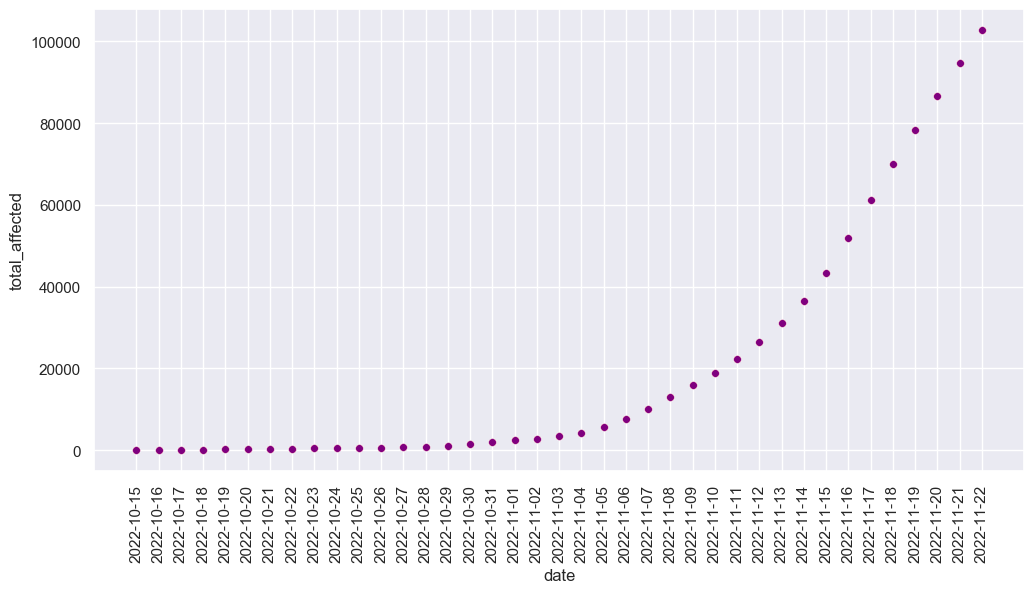

In [171]:
gt = data_modeling.iloc[:]
ser = gt.iloc[:]
sns.scatterplot(x=gt.date, y=gt.total_affected, alpha=1.0, color="blue", s=32)
sns.scatterplot(x=ser.date, y=ser.total_affected, alpha=0.5, color="red", s=32)
_ = plt.xticks(gt.date, rotation=90)

In [ ]:
growth_flag, turning_point, stop_point, seer_ser = covid19_seer(
    ser.total_affected.values, "LOCKDOWN", theta_city
)

inter 0: Theta: [0.59895091 1.00398787 1.70990562] Loss: 14181.400801583175
inter 1: Theta: [0.59890231 1.00397601 1.70981224] Loss: 14186.257277672401
inter 2: Theta: [0.59885418 1.00396444 1.70971983] Loss: 14191.109240138523
inter 3: Theta: [0.59880653 1.00395313 1.7096284 ] Loss: 14195.955745726598
inter 4: Theta: [0.59875935 1.00394209 1.70953792] Loss: 14200.795884578427
inter 5: Theta: [0.59871263 1.0039313  1.70944841] Loss: 14205.628779241792
inter 6: Theta: [0.59866637 1.00392076 1.70935984] Loss: 14210.453583710518
inter 7: Theta: [0.59862056 1.00391046 1.70927221] Loss: 14215.269482494827
inter 8: Theta: [0.59857521 1.00390041 1.7091855 ] Loss: 14220.075689720328
inter 9: Theta: [0.5985303  1.00389058 1.70909972] Loss: 14224.87144825534
inter 10: Theta: [0.59848583 1.00388098 1.70901485] Loss: 14229.656028864934
inter 11: Theta: [0.5984418  1.00387161 1.70893088] Loss: 14234.428729390962
inter 12: Theta: [0.5983982  1.00386245 1.70884781] Loss: 14239.188873957246
inter 13: 

array([0.599, 1.004, 1.71 ])

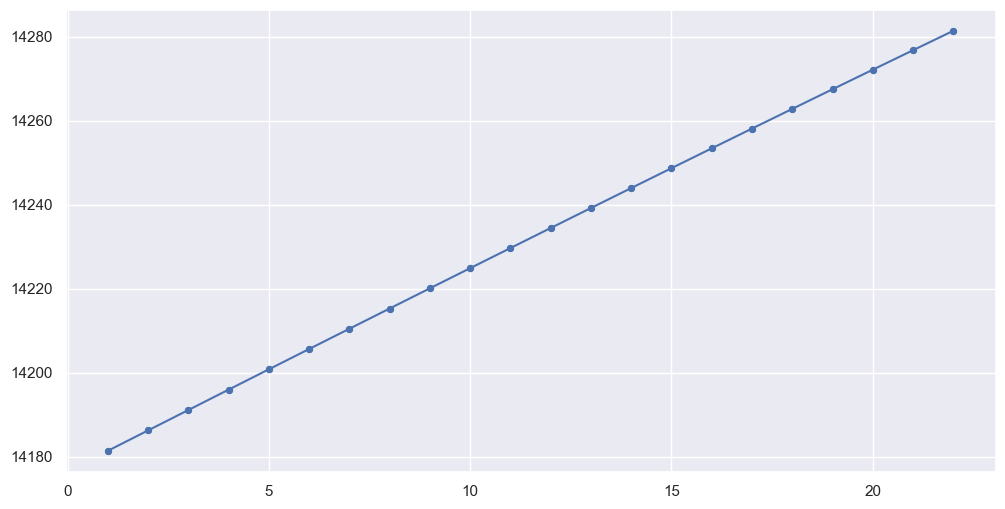

In [177]:
kappa_init, mu_init, tau_init = [0.599, 1.004, 1.71]

theta_opt, losses, fitted_opt, bs_funcs = model_theta_global_opt(
    ser.total_affected.values,
    kappa_init=kappa_init,
    mu_init=mu_init,
    tau_init=tau_init,
    bs_interp_prop=0.5,
    interg_interp_prop=200.0,
    labd=5.0,
    bs_lr_schedule=(int(4e2), 0.02, 0.999),
    theta_lr_schedule=(int(5e2), 0.01, 0.99),
    early_stop_ratio=[2.0, 0.99999],
    early_stop_steps=20,
    show_process="outer",
    ser_loss_expansion=0.5,
)
theta_opt

<AxesSubplot:>

<AxesSubplot:>

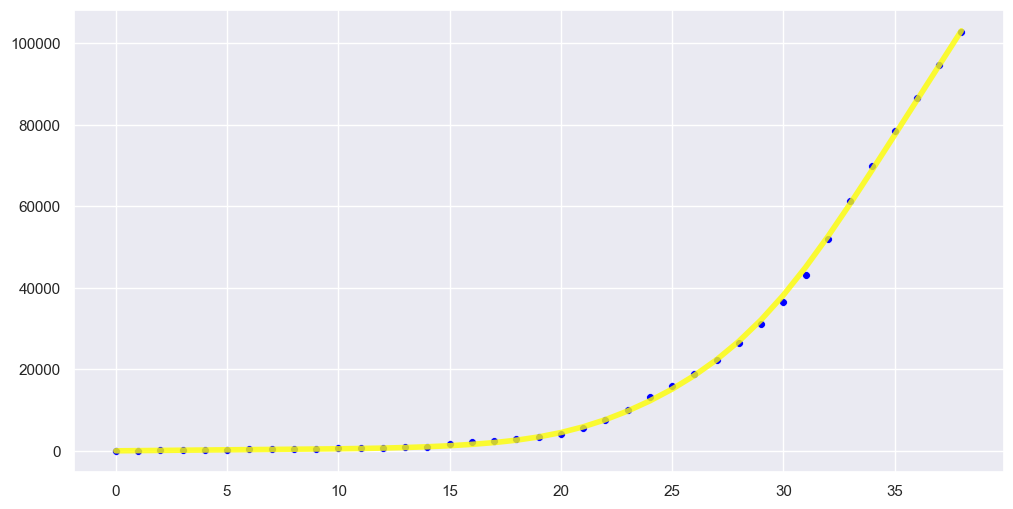

In [178]:
sns.scatterplot(
    x=range(len(ser.total_affected.values)),
    y=ser.total_affected.values,
    alpha=1.0,
    color="blue",
    s=32,
)
sns.lineplot(
    x=range(len(ser.total_affected.values)),
    y=revise_ser(fitted_opt),
    alpha=0.8,
    color="yellow",
    linewidth=4,
)

In [221]:
print("kappa: {} mu: {} tau :{}".format(theta_opt[0],theta_opt[1],theta_opt[2]))

kappa: 0.599 mu: 1.004 tau :1.71


In [184]:
theta_opt_adj = theta_opt  # [0.599, 1.00, 1.71]
theta_opt_adj
pred_len = 30
pred_interp = 10
pred_prev_len = 2
use_gt = 0
fitted_ser = revise_ser(
    np.concatenate([fitted_opt[:-use_gt], ser.total_affected.values[-use_gt:]])
)
pred_ser_combo = pred_ser(
    fitted_ser, pred_len, pred_interp, pred_prev_len, theta_opt_adj
)
pred_series = pred_ser_combo[pred_interp * pred_prev_len :][::pred_interp]
pred_series_upper = revise_ser(pred_series, intercept=pred_series[0])

array([0.599, 1.004, 1.71 ])

In [185]:
theta_opt_adj = [0.599, 1.008, 1.71]
theta_opt_adj
pred_len = 30
pred_interp = 10
pred_prev_len = 2
use_gt = 0
fitted_ser = revise_ser(
    np.concatenate([fitted_opt[:-use_gt], ser.total_affected.values[-use_gt:]])
)
pred_ser_combo = pred_ser(
    fitted_ser, pred_len, pred_interp, pred_prev_len, theta_opt_adj
)
pred_series = pred_ser_combo[pred_interp * pred_prev_len :][::pred_interp]
pred_series_lower = revise_ser(pred_series, intercept=pred_series[0])

[0.599, 1.008, 1.71]

In [187]:
theta_opt_adj = [0.599, 1.006, 1.71]
theta_opt_adj
pred_len = 30
pred_interp = 10
pred_prev_len = 2
use_gt = 0
fitted_ser = revise_ser(
    np.concatenate([fitted_opt[:-use_gt], ser.total_affected.values[-use_gt:]])
)
pred_ser_combo = pred_ser(
    fitted_ser, pred_len, pred_interp, pred_prev_len, theta_opt_adj
)
pred_series = pred_ser_combo[pred_interp * pred_prev_len :][::pred_interp]
pred_series_mean = revise_ser(pred_series, intercept=pred_series[0])

[0.599, 1.006, 1.71]

In [213]:
pred_x_range = pd.date_range("2022-11-22","2022-12-22",freq="D")

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

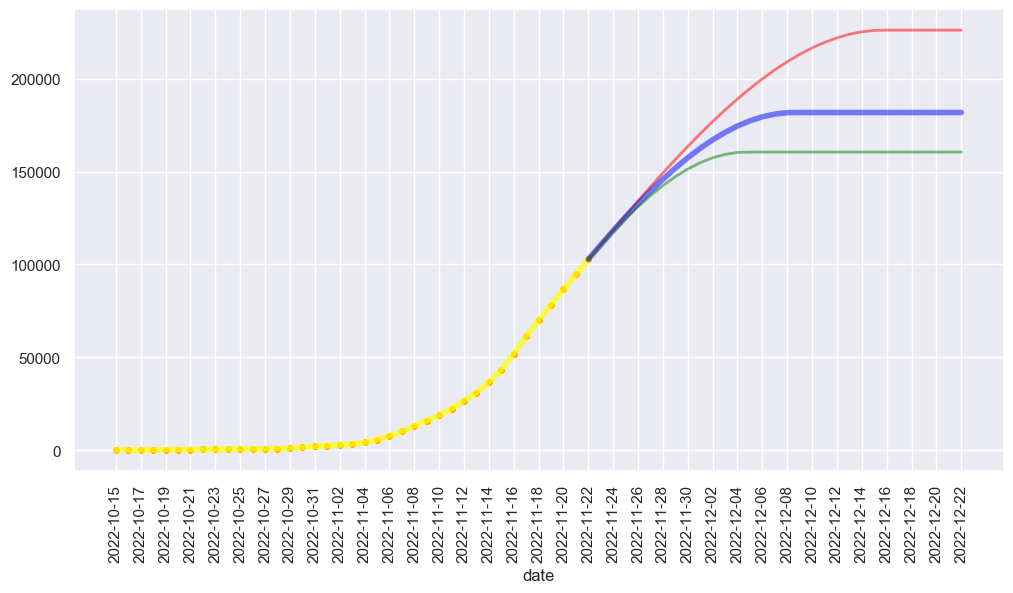

In [220]:
sns.lineplot(
    x=ser.date, y=fitted_ser, alpha=0.7, color="yellow", linewidth=4
)

sns.scatterplot(
    x=ser.date, y=ser.total_affected.values, alpha=1.0, color="orange", s=32
)

sns.lineplot(
    x=pred_x_range,
    y=pred_series_upper,
    alpha=0.5,
    color="red",
    linewidth=2,
)

sns.lineplot(
    x=pred_x_range,
    y=pred_series_mean,
    alpha=0.5,
    color="blue",
    linewidth=4,
)

sns.lineplot(
    x=pred_x_range,
    y=pred_series_lower,
    alpha=0.5,
    color="green",
    linewidth=2,
)

_ = plt.xticks(pd.date_range("2022-10-15","2022-12-22",freq="2D"), rotation=90)